# Brian tutorial: neurons

In [1]:
%matplotlib inline
from brian2 import *
prefs.codegen.target = 'numpy'  # this switches off fancy code generation for now

## Brian's unit system

All the standard SI units are available using their name (volt, siemens, meter (or metre), second, etc.), together with standard prefixes n (nano), u (micro), m (milli), k (kilo), M (mega), etc.

Because it would lead to clashes with user-defined variable names too often, single letter names are *not* defined (e.g. no `s` or `m`), but for convenience the most commonly used abbreviations for neuroscience are available (e.g. `ms` instead of `msecond`, `mV` instead of `mvolt`, `nS` instead of `nsiemens`, etc.)

Brian complains when using physical quantities incorrectly

In [2]:
5*volt + 3*mV  # Brian is aware of the different magnitudes

5.003 * volt

In [3]:
25*um*25*um  # Multiplication, etc. changes the units

625. * umetre2

In [4]:
x = [-70, -80, -70]*mV  # short-hand notation to create an array of values
x

array([-70., -80., -70.]) * mvolt

In [5]:
np.mean(x)  # most numpy functions can be used with units as well

-73.33333333 * mvolt

In [6]:
x/mV  # division gets rid of units (e.g. to use it with functions that are not compatible)

array([-70., -80., -70.])

In [7]:
5*mV + 3*ms  # does not make sense

DimensionMismatchError: Cannot calculate 5. mV + 3. ms, units do not match (units are volt and second).

## Neural dynamics

Membrane potential equation:
$$
C_m\frac{d V_m}{dt} = I + g_L (E_L - V_m)
$$

In [8]:
start_scope()
# The default integration time step is 0.1ms, to chose a different one use:
defaultclock.dt = 0.05*ms

Cm = 200*pF
E_L = -70*mV
I = 1.5*nA

eqs = '''
dVm/dt = (I + g_L*(E_L - Vm))/Cm : volt
g_L : siemens
'''
group = NeuronGroup(10, eqs, method='exact')
group.Vm = E_L
group.g_L = '10*nS + rand()*5*nS'

mon = StateMonitor(group, 'Vm', record=[0, 5, 7])
# mon = StateMonitor(group, 'Vm', record=True)  # records all values 
run(100*ms, report='text')

Starting simulation at t=0. s for a duration of 100. ms
0.1 (100%) simulated in < 1s


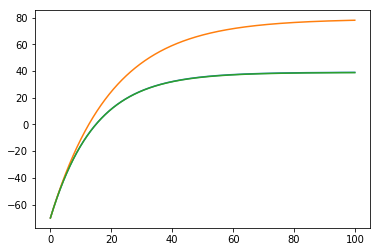

In [9]:
# mon.V_m has shape (number of neurons, number of time steps), so we have to transpose it
# to have its first dimension match the dimension of mon.t
plt.plot(mon.t/ms, mon.Vm.T/mV);  # the ";" avoids annoying output in the notebook

### [Exercise: time dependent current]

Replace the injected current in the model above by a current that changes in time.

*Hints:*

* Equations can refer to all defined constants and variables, as well as to a few standard variables/constants that are predefined, e.g.:

`N` (number of neurons in the group), `i` (index of the neuron), `t` (current time), `dt` (the time step used for the simulation)
* Equations can make use of standard mathematical functions, e.g. `exp`, `sin`, `sqrt`, ...
* Equations can be made more readable by introducing "subexpressions", i.e. short names for longer terms. For example, the following two definitions do the same thing:


```Python
eqs = '''
dv/dt = 1/Cm * (I + g_L * (E_L - v)) : volt
'''
eqs = '''
dv/dt = 1/Cm * (I_inj + g_L * (E_L - v)) : volt
I_inj = 1.0 * I : amp 
'''
```

In [10]:
# Example solution

start_scope()

defaultclock.dt = 0.05*ms

Cm = 200*pF
E_L = -70*mV
f = 100*Hz

eqs = '''
dVm/dt = (I_inj + g_L*(E_L - Vm))/Cm : volt
g_L : siemens
I_inj = sin(2*pi*f*t)*2*nA : amp  # time-varying current
'''
group = NeuronGroup(10, eqs, method='euler')
group.Vm = E_L
group.g_L = '10*nS + rand()*5*nS'

mon = StateMonitor(group, 'Vm', record=[0, 5, 7])
# mon = StateMonitor(group, 'Vm', record=True)  # records all values 
run(100*ms, report='text')

Starting simulation at t=0. s for a duration of 100. ms
0.1 (100%) simulated in < 1s


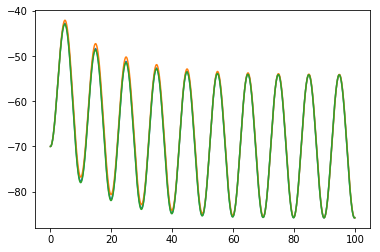

In [11]:
plt.plot(mon.t/ms, mon.Vm.T/mV);

## Spiking neurons

Integrate-and-fire neuron models (like the model we are using here), only model the "passive" neuron, i.e. only its subthreshold state and not the generation of action potentials. Action potentials are counted whenever the membrane potential crosses a threshold and then the membrane potential is reset to a lower value.

Starting simulation at t=0. s for a duration of 100. ms
0.1 (100%) simulated in < 1s


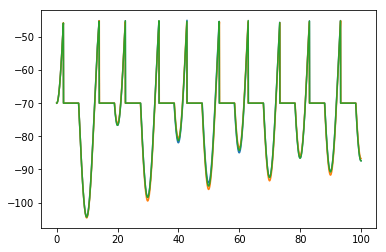

In [12]:
# Spiking neuron (Vm does not change during the refractory period)
start_scope()
defaultclock.dt = 0.05*ms

Cm = 200*pF
E_L = -70*mV
f = 100*Hz

eqs = '''
dVm/dt = (I_inj + g_L*(E_L - Vm))/Cm : volt (unless refractory)
g_L : siemens
I_inj = sin(2*pi*f*t)*4*nA : amp
'''
group = NeuronGroup(10, eqs, threshold='Vm > -45*mV',
                    reset='Vm = E_L',
                    refractory=5*ms, method='euler')
group.Vm = E_L
group.g_L = '10*nS + rand()*5*nS'

mon = StateMonitor(group, 'Vm', record=[0, 5, 7])
spike_mon = SpikeMonitor(group)

# mon = StateMonitor(group, 'Vm', record=True)  # records all values 
run(100*ms, report='text')
plt.plot(mon.t/ms, mon.Vm.T/mV);

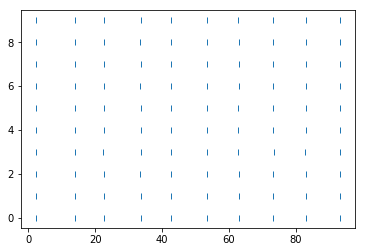

In [13]:
# Raster plot
plt.plot(spike_mon.t/ms, spike_mon.i, '|');

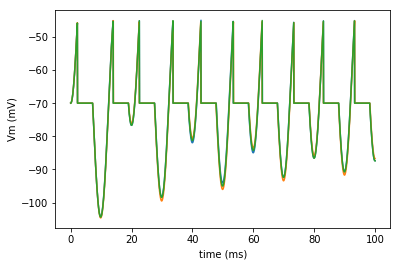

In [14]:
# The brian2tools package provides useful tools, e.g. for quick visualization:
from brian2tools import *
brian_plot(mon);

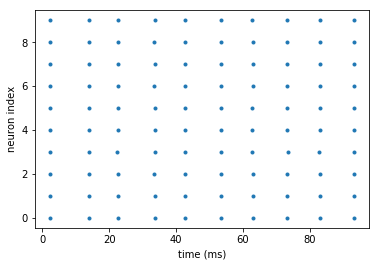

In [15]:
brian_plot(spike_mon);